# Residual Networks

- 앞선 네트워크에서 설명한 부분은 생략했습니다.
- 2015 ILSVRC 1st place
- ResNet-50

![alt text](https://www.codeproject.com/KB/AI/1248963/resnet.png)


In [1]:
# 런타임 유형 GPU 모드로 변경
# !pip install torch torchvision
# !pip install pillow==4.1.1
# %reload_ext autoreload
# %autoreload

In [2]:
!rm -r images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs
  
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

rm: cannot remove 'images': No such file or directory
--2021-02-11 06:32:49--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.2.166, 151.101.194.166, 151.101.66.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.2.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0s      

2021-02-11 06:32:49 (134 MB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg’ saved [32099/32099]

--2021-02-11 06:32:49--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.86.38
Connecting to www.rspcansw.org.au (www.rspcansw.org.au)|101.0.86.38|:443... connected.
HTTP request sent, awaiting res

## 1. Settings
### 1) Import required libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

### 2) Hyperparameter

In [4]:
batch_size = 1
learning_rate = 0.0002
num_epoch = 100

## 2. Data Loader

In [5]:
img_dir = "./images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                                      transforms.Resize(256),                   
                                      transforms.RandomResizedCrop(224),        
                                      transforms.RandomHorizontalFlip(),        
                                      transforms.ToTensor(),                    
            ]))

train_loader = data.DataLoader(img_data, 
                               batch_size = batch_size,
                               shuffle = True, 
                               num_workers = 2)

## 3. Model 
### 1) Basic Block

- 컨볼루션 연산과 활성화함수는 항상 붙어 있기 때문에 이를 함수로 만들었습니다.

In [6]:
def conv_block_1(in_dim, out_dim, act_fn, stride = 1):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size = 1, stride = stride),
        act_fn
    )
    return model

def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size = 3, stride = 1, padding = 1),
        act_fn
    )
    return model

### 2) Bottle Neck Module
- Bottle Neck 모듈은 **[1x1 컨볼루션 -> 3x3 컨볼루션 -> 1x1 컨볼루션]**으로 이루어집니다.
- 맨 위에 네트워크 구조에서도 볼 수 있듯이 실선은 Feature Map의 크기가 변하지 않는 경우, 점선은 Feature Map의 크기가 줄어드는 경우입니다. 
  - 이를 한번에 구현하기 위해 down이라는 변수로 크기 감소 여부를 표시하고 조건문으로 경우의 수를 나눠 구현했습니다.
- 또한 ResNet의 Skip-connection은 단순 더하기로 정의되어 있기 때문에 Feature Map의 크기를 일치시켜야 합니다. 
  - 이를 위해 차원을 맞춰주는 역할로 ```dim_equalizer```라는 것을 정의했습니다.

In [7]:
class BottleNeck(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim, act_fn, down = False):
        super(BottleNeck,self).__init__()
        self.act_fn = act_fn # 활성화 함수 설정
        self.down = down
        
        # Feature Map의 크기가 감소하는 경우
        if self.down:
            self.layer = nn.Sequential(
              conv_block_1(in_dim, mid_dim, act_fn, 2),         # stride = 2
              conv_block_3(mid_dim, mid_dim, act_fn),
              conv_block_1(mid_dim, out_dim, act_fn)
            )
            self.downsample = nn.Conv2d(in_dim, out_dim, 1, 2)  # stride = 2
            
        # Feature Map의 크기가 그대로인 경우
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_dim, mid_dim, act_fn),
                conv_block_3(mid_dim, mid_dim, act_fn),
                conv_block_1(mid_dim, out_dim, act_fn)
            )
            
        # 채널의 개수가 달라서 더해지지 않는 경우를 방지하기 위해,
        # 차원을 맞춰주는 1 x 1 합성곱을 추가해 입력의 채널 개수와 출력의 채널 개수를 같게 만들어줍니다.
        self.dim_equalizer = nn.Conv2d(in_dim, out_dim, kernel_size = 1)
                  
    def forward(self, x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out

### 2) ResNet Model

In [8]:
class ResNet(nn.Module):
    def __init__(self, base_dim, num_classes = 2):
        super(ResNet, self).__init__()
        self.act_fn = nn.ReLU() # 활성화 함수로 ReLU 함수를 설정

        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, base_dim, 7, 2, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1)
        )

        self.layer_2 = nn.Sequential(
            BottleNeck(base_dim, base_dim, base_dim * 4, self.act_fn),
            BottleNeck(base_dim * 4, base_dim, base_dim * 4, self.act_fn),
            BottleNeck(base_dim * 4, base_dim, base_dim * 4, self.act_fn, down = True)         # Down Sampling
        )   

        self.layer_3 = nn.Sequential(
            BottleNeck(base_dim * 4, base_dim * 2, base_dim * 8, self.act_fn),
            BottleNeck(base_dim * 8, base_dim * 2, base_dim * 8, self.act_fn),
            BottleNeck(base_dim * 8, base_dim * 2, base_dim * 8, self.act_fn),
            BottleNeck(base_dim * 8, base_dim * 2, base_dim * 8, self.act_fn, down = True)     # Down Sampling
        )

        self.layer_4 = nn.Sequential(
            BottleNeck(base_dim * 8, base_dim * 4, base_dim * 16, self.act_fn),
            BottleNeck(base_dim * 16, base_dim * 4, base_dim * 16, self.act_fn),
            BottleNeck(base_dim * 16, base_dim * 4, base_dim * 16, self.act_fn),            
            BottleNeck(base_dim * 16, base_dim * 4, base_dim * 16, self.act_fn),
            BottleNeck(base_dim * 16, base_dim * 4, base_dim * 16, self.act_fn),
            BottleNeck(base_dim * 16, base_dim * 4, base_dim * 16, self.act_fn, down = True)   # Down Sampling
        )

        self.layer_5 = nn.Sequential(
            BottleNeck(base_dim * 16, base_dim * 8, base_dim * 32, self.act_fn),
            BottleNeck(base_dim * 32, base_dim * 8, base_dim * 32, self.act_fn),
            BottleNeck(base_dim * 32, base_dim * 8, base_dim * 32, self.act_fn)
        )

        self.avgpool = nn.AvgPool2d(7, 1) 
        self.fc_layer = nn.Linear(base_dim * 32, num_classes)
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.avgpool(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        
        return out

## 4. Optimizer & Loss

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    
model = ResNet(base_dim = 64).to(device)
for i in model.children():
    print(i)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

cuda:0
ReLU()
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)
Sequential(
  (0): BottleNeck(
    (act_fn): ReLU()
    (layer): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (dim_equalizer): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): BottleNeck(
    (act_fn): ReLU()
    (layer): Sequential(
      (0): Sequential(
        (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

## 5. Train

In [10]:
loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(0.8460, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0478, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4286, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4224, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0980, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4032, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4180, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4287, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0998, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0661, device='cuda:0', grad_fn=<NllLossBackward>)


In [11]:
param_list = list(model.parameters())
print(param_list)

[Parameter containing:
tensor([[[[-0.0695, -0.0782,  0.0165,  ..., -0.0044,  0.0626, -0.0588],
          [-0.0708,  0.0149,  0.0229,  ..., -0.0608,  0.0479, -0.0005],
          [-0.0716,  0.0521,  0.0681,  ...,  0.0300, -0.0562,  0.0175],
          ...,
          [ 0.0360,  0.0322, -0.0431,  ...,  0.0217, -0.0728,  0.0329],
          [-0.0631, -0.0252, -0.0670,  ...,  0.0068, -0.0326,  0.0246],
          [-0.0538, -0.0139, -0.0519,  ..., -0.0029, -0.0327,  0.0654]],

         [[-0.0555,  0.0307,  0.0035,  ...,  0.0114,  0.0119,  0.0563],
          [-0.0557, -0.0368,  0.0728,  ...,  0.0003,  0.0849,  0.0581],
          [ 0.0346, -0.0166,  0.0229,  ..., -0.0032, -0.0508, -0.0757],
          ...,
          [-0.0465,  0.0043, -0.0370,  ...,  0.0186, -0.0785, -0.0634],
          [ 0.0401,  0.0547,  0.0735,  ..., -0.0489, -0.0631, -0.0529],
          [ 0.0839, -0.0604, -0.0192,  ...,  0.0360, -0.0294, -0.0758]],

         [[ 0.0480,  0.0843, -0.0696,  ..., -0.0727,  0.0546,  0.0817],
       

## 6. Visualize Training Loss

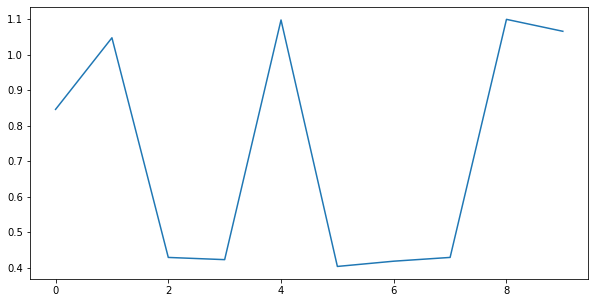

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(loss_arr)
plt.show()